In [336]:
from sklearn.datasets import fetch_openml
import pandas as pd
from sklearn import preprocessing
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import GPy
from scipy import stats
from scipy import optimize
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from tqdm import tqdm
from functools import partial

# http://krasserm.github.io/2018/03/21/bayesian-optimization/

# Expected Improvement

[derivation](http://ash-aldujaili.github.io/blog/2018/02/01/ei/)

$$\text{EI}(x) = \mathbb{E}\max(f(x^*) - f(x^+), 0)$$

$$\text{EI}(x) = (\mu(x^*) - f(x^+)) \Phi(\frac{\mu(x^*) - f(x^+)}{\sigma(x^*)}) + \sigma(x^*) \phi(\frac{\mu(x^*) - f(x^+)}{\sigma(x^*)})$$

* $\Phi$ = CDF standard normal
* $\phi$ = PDF standard normal
* $x^*$ = proposed points
* $x^+$ = current best

Numerrically unstable if $\sigma \to 0$

$$\text{EI}(x) = (\mu(x^*) - f(x^+)) \Phi(Z) + \sigma \phi(Z)$$

$$Z = \begin{cases}
    \frac{\mu(x^*) - f(x^+)}{\sigma(x^*)},& \text{if } \sigma(x^*) > 0 \\
    0,              & \text{otherwise}
\end{cases}$$

Let $\mu(x^*) - f(x^+) := \delta$.

$$Z = \begin{cases}
    \frac{\delta}{\sigma(x^*)},& \text{if } \sigma(x^*) > 0 \\
    0,              & \text{otherwise}
\end{cases}$$

$$\text{EI}(x) = (\delta) \Phi(Z) + \sigma \phi(Z)$$

Recommendation value for $\xi = 0.01$. 


In [391]:

def select_hyperparams_random(param_ranges):
    selection = {}
    for k in param_ranges:
        val = np.random.choice(
            np.linspace(*param_ranges[k]['range'], num=100)
        )
        
        dtype = param_ranges[k]['type']
        if dtype is 'int':
            val = int(val)
        selection[k] = val
    return selection


def expected_improvement(f, y_current, x_proposed):
    """
    Return E(max(f_proposed - f_current), 0)
    
    Parameters
    ----------

    f : GP predict function
    y_current : float
        Current best score
    x_proposed : np.array
        Proposal parameters. Shape: (1, 1)
    xi : float
        Exploration parameter
    
    Returns
    -------
    expected_improvement : float
        E(max(f_proposed - f_current), 0)
    
    """
    mu, var = f(x_proposed)
    std = var**0.5
    delta = mu - y_current
    
    # x / inf = 0
    std[std == 0] = np.inf
    z = delta / std
    unit_norm = stats.norm()
    return delta * unit_norm.cdf(z) + std * unit_norm.pdf(z)



hp = select_hyperparams_random(param_ranges)
print('Randomly selected hyper parameters:', hp)


Randomly selected hyper parameters: {'x': 9.545454545454545}


In [401]:
class BayesOpt:
    def __init__(self, 
                 param_ranges, 
                 f, 
                 random_trials=5, 
                 optimization_trials=30,
                 ):
        """
        Parameters
        ----------
        
        param_ranges : dict
        f : function
        """
        self.param_ranges = param_ranges
        self.f = f
        self.random_trials = random_trials
        self.optimization_trials = optimization_trials
        self.n_trials = random_trials + optimization_trials
        self.x = np.zeros((self.n_trials, len(param_ranges)))
        self.y = np.zeros((self.n_trials, 1))
        self.kernel = GPy.kern.RBF(input_dim=self.x.shape[1], 
                                   variance=1,
                                   lengthscale=1) 
        self.gp = None
        self.bounds = np.array([pr['range'] for pr in param_ranges.values()])
        
    @property
    def best_params(self):
        return self._prepare_kwargs(self.x[self.y.argmax()])
                
    def fit(self):
        self._random_search()
        self._bayesian_search()
            
    def _random_search(self):
        print(f'Starting {self.random_trials} random trials...')
        for i in tqdm(range(self.random_trials)):
            hp = select_hyperparams_random(self.param_ranges)
            self.x[i] = np.array(list(hp.values()))
            self.y[i] = evaluate_params(hp)
            
    def _bayesian_search(self):
        print(f'Starting {self.optimization_trials} optimization trials...')
        for i in tqdm(range(self.random_trials, 
                       self.random_trials + self.optimization_trials)):
            self.x[i], self.y[i] = self._single_iter()
    
    def _single_iter(self):
            self._fit_gp()
            x = self._new_proposal()
            y = evaluate_params(self._prepare_kwargs(x))
            return x, y
        
        
    def _fit_gp(self, noise_var=0):
        mask = self.x.sum(axis=1) != 0
        self.gp = GPy.models.GPRegression(bo.x[mask], 
                                     bo.y[mask], 
                                     normalizer=True, 
                                     kernel=self.kernel,
                                     noise_var=noise_var)
        self.gp.optimize()
        
    def _new_proposal(self, n=25):
        def f(x):
            return -expected_improvement(
                f=self.gp.predict,
                y_current=self.y.max(),
                x_proposed=x[None, :]
            )
        x0 = np.random.uniform(
            low=self.bounds[:, 0],
            high=self.bounds[:, 1],
            size=(n, self.x.shape[1])
        )
        proposal = None
        best_ei = np.inf
        for x0_ in x0:
            res = optimize.minimize(f, 
                                    x0_, 
                                    bounds=self.bounds)
            if res.success and res.fun < best_ei:
                best_ei = res.fun
                proposal = res.x
            if np.isnan(res.fun):
                raise ValueError('NaN within bounds')
        return proposal
    
    def _prepare_kwargs(self, x):
        # create hyper parameter dict
        hp = dict(zip(self.param_ranges.keys(), x))
        # cast values
        for k in self.param_ranges:
            if self.param_ranges[k]['type'] == 'int':
                hp[k] = int(hp[k])
            elif self.param_ranges[k]['type'] == 'float':
                hp[k] = float(hp[k])
            else:
                raise ValueError('Parameter type not known')
        return hp

                
bo = BayesOpt(param_ranges, evaluate_params)
# bo.fit()

# 1D

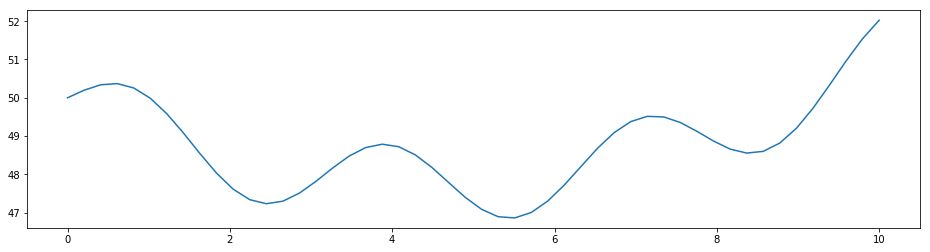

In [402]:
x = np.linspace(0, 10)

def func(x):
    return np.sin(2 * x) + (x / 3)**2 - x + 50

plt.figure(figsize=(16, 4))
plt.plot(x, func(x))

np.random.seed(1)
bo = BayesOpt(param_ranges, evaluate_params)


In [403]:
def evaluate_params(hyperparams):
    return func(**hyperparams)

param_ranges = {
    'x': {
        'range': [1, 10],
        'type': 'float'
    }
}


100%|██████████| 2/2 [00:00<00:00, 5210.32it/s]

Starting 2 random trials...


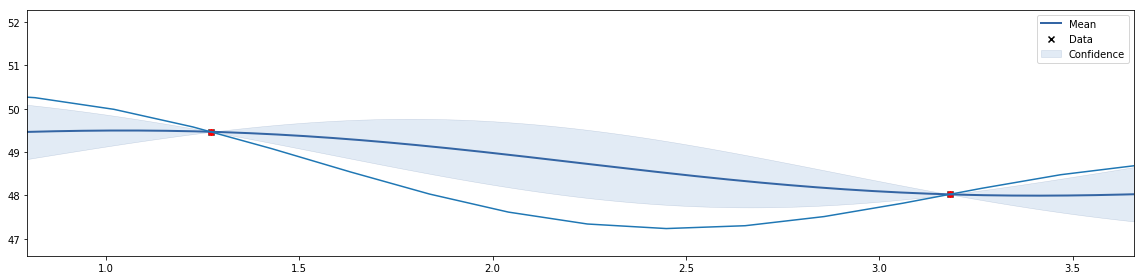

In [438]:
np.random.seed(3)
bo = BayesOpt(param_ranges, 
              evaluate_params, 
             random_trials=2)

bo._random_search()
bo._fit_gp()
bo.gp.plot(plot_density=0, figsize=(16, 4))
plt.scatter(bo.x[:bo.random_trials], bo.y[:bo.random_trials], color='r')
plt.plot(x, func(x))

  0%|          | 0/5 [00:00<?, ?it/s]

Starting 2 random trials...
Starting 5 optimization trials...


100%|██████████| 5/5 [00:01<00:00,  3.41it/s]


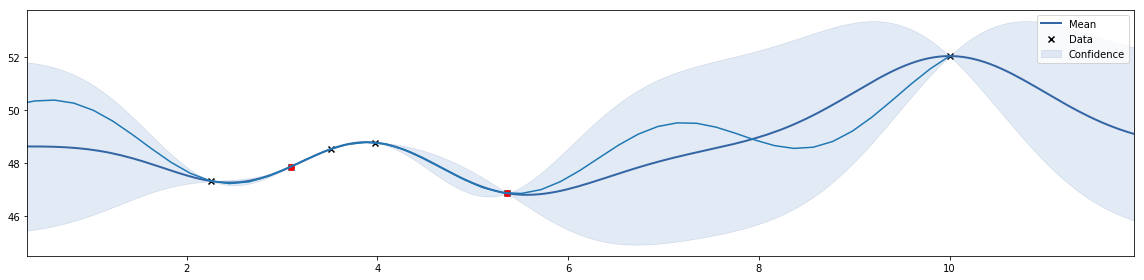

In [436]:
# np.random.seed(3)
bo = BayesOpt(param_ranges, evaluate_params, random_trials=2, optimization_trials=5)
bo.fit()
bo.gp.plot(plot_density=0, figsize=(16, 4))
plt.plot(x, func(x))
plt.scatter(bo.x[:bo.random_trials], bo.y[:bo.random_trials], color='r')

In [437]:
bo.best_params

{'x': 10.0}

In [407]:
bo._new_proposal(n=25)

array([4.47201616])

{'dataplot': [<matplotlib.collections.PathCollection at 0x7f7eb343a908>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7f7eb343a8d0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7f7eb343add8>]}

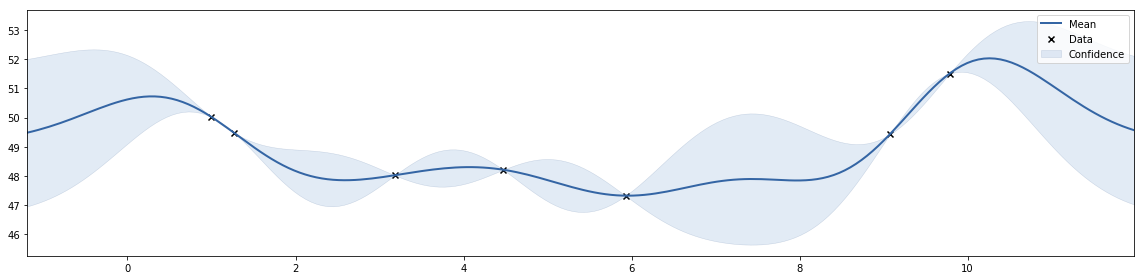

In [398]:
bo._fit_gp()
bo.gp.plot(plot_density=0, figsize=(16, 4))


In [261]:
# np.random.seed(1)
bo = BayesOpt(param_ranges, evaluate_params, xi=0.05, random_trials=10)
bo._random_search()

100%|██████████| 10/10 [00:00<00:00, 13648.89it/s]

Starting 10 random trials...


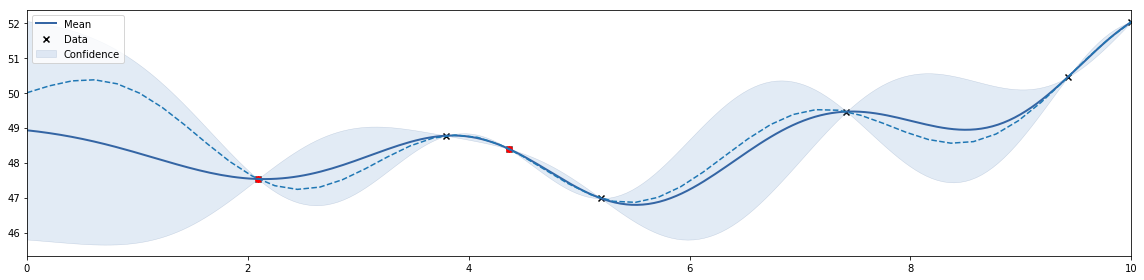

In [364]:
bo._fit_gp()
bo.gp.plot(plot_density=0, figsize=(16, 4), plot_limits=[0, 10])
plt.plot(x, func(x), ls='--')
plt.scatter(bo.x[:bo.random_trials], bo.y[:bo.random_trials], color='r')

In [356]:
bo._new_proposal(n=25)

array([1.])

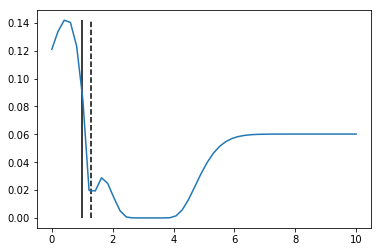

In [385]:
ei = expected_improvement(
            f=bo.gp.predict,
            y_current=bo.y.max(),
            x_proposed=x[:, None],
            xi=0
)

plt.plot(x, ei)
plt.vlines(bo._new_proposal(), 0, max(ei))
plt.vlines(bo.x[bo.y.argmax()], 0, max(ei), linestyle='--')

In [151]:
def optim_f(x):
    return -expected_improvement(
        f=bo.gp.predict,
        y_current=bo.y.max(),
        x_proposed=x[None, :],
        xi=bo.xi)


x0 = np.random.uniform(
    low=bo.bounds[:, 0],
    high=bo.bounds[:, 1],
    size=(25, bo.x.shape[1])
)
proposal = None
best_ei = np.inf
for x0_ in x0:
    res = optimize.minimize(optim_f, 
                            x0_, 
                            bounds=bo.bounds)

In [153]:
ei_along_axis([8.94396671])

array([0.05296022])

## With real data

In [2]:
fetch = fetch_openml('SpeedDating')
fetch.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
df = pd.DataFrame(fetch.data, columns=fetch.feature_names)
# make it a bit harder
df = df.drop([
    'samerace', 'sincere_important', 'age_o', 'shared_interests_important', 'pref_o_attractive', 'exercise', 'd_like', 'hiking', 'art', 'concerts', 'sports', 'pref_o_intelligence', 'pref_o_sincere', 'pref_o_ambitious', 'intellicence_important', 'pref_o_funny', 'funny_partner', 'attractive_important', 'interests_correlate', 'guess_prob_liked', 'funny_o', 'expected_num_matches', 'shared_interests_o', 'attractive_partner', 'attractive_o', 'like',
    'clubbing', 'expected_happy_with_sd_people', 'importance_same_race', 'attractive', 'ambtition_important', 'd_d_age', 'race', 'reading', 'expected_num_interested_in_me', 'd_ambitous_o', 'd_interests_correlate', 'sincere', 'intelligence', 'movies', 'd_pref_o_sincere', 'importance_same_religion', 'd_funny_partner', 'd_pref_o_attractive', 'sincere_partner', 'tvsports', 'race_o', 'museums', 'funny_important', 'gaming', 'intelligence_o', 'ambitous_o', 'd_shared_interests_o', 'sinsere_o', 'intelligence_partner', 'field', 'ambition_partner', 'd_age', 'age', 'd_guess_prob_liked', 'pref_o_shared_interests', 'd_funny_o', 'd_attractive_partner', 'd_attractive_o', 'shared_interests_partner']
, axis=1)

df.head()

,has_null,wave,gender,d_importance_same_race,d_importance_same_religion,d_pref_o_intelligence,d_pref_o_funny,d_pref_o_ambitious,d_pref_o_shared_interests,d_sinsere_o,...,d_theater,d_movies,d_concerts,d_music,d_shopping,d_yoga,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,met
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
x_train, x_test, y_train, y_test = train_test_split(df, fetch.target)

In [5]:
imputer = preprocessing.Imputer(strategy='mean')
x_train = imputer.fit_transform(x_train)
x_test = imputer.transform(x_test)


In [ ]:
# decision tree
param_ranges = {
    'min_samples_split': {
        'range': [2, 10],
        'type': 'int'
    },
    'min_samples_leaf': {
        'range': [1, 10],
        'type': 'int'
    },
    'max_depth': {
        'range': [3, 1000],
        'type': 'int'
    }
}

# nn
param_ranges = {
    'hidden_layer_sizes': {
        'range': [1, 10],
        'type': 'int'
    },
    'batch_size': {
        'range': [10, 100],
        'type': 'int'
    },
    'learning_rate_init': {
        'range': [0.00001, 0.01],
        'type': 'float'
    }
}

def evaluate_params(hyperparams):
    m = MLPClassifier(**hyperparams)
    m.fit(x_train, y_train)
    return m.score(x_test, y_test)